## Neural Network Approach For Functions Of Matrices

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import numpy as np
from scipy.linalg import expm
import math

import matplotlib.pyplot as plt

import csv
import os

import datetime
import logging


In [2]:
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [3]:
logger = logging.getLogger()
# fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# fhandler.setFormatter(formatter)
# logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
logger.info("Setup logging")

10:04:57 INFO:Setup logging


In [4]:
ID = datetime.datetime.strftime(datetime.datetime.now(),'%Y%M%d%s')

In [5]:
# Create a directory for saving results
save_dir = os.path.join(os.getcwd(), 'matrix_exp_results', ID)
os.makedirs(save_dir, exist_ok=True)
logger.info(f"Results saved at: {save_dir}")

10:04:57 INFO:Results saved at: /home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/notebooks/matrix_exp_results/202404191724119497


In [6]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

10:04:57 INFO:Using device: cuda


In [7]:
# Define the neural network
class MatrixExponentialNet(nn.Module):
    def __init__(self, input_size):
        super(MatrixExponentialNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [9]:
# params
distribution = "gaussian" # or uniform
matrix_type = "wigner"
coeff_lower = -1
coeff_upper = 2
batch_size = 256
num_epochs = 1000

total_samples = 100000
validation_interval = 100

dim = 1

lr = 1e-3 # learning rate

In [10]:
class ExperimentData(Dataset):
    "Dataset for generating data about the exponential"

    def __init__(self, n_examples, dim, distribution, matrix_type='', coeff_upper=1, f_type="matrix", operation="square"):
        super().__init__()
        self.n_examples = n_examples
        self.dim = dim
        self.distribution = distribution
        self.matrix_type = matrix_type

        if self.distribution == "gaussian":
            self.data = torch.randn(n_examples, dim, dim)
            if coeff_upper is not None:
                self.data = coeff_upper / math.sqrt(3.0) * self.data
        elif self.distribution == "uniform":
            self.data = torch.rand(n_examples, dim, dim)
            if coeff_upper is not None:
                self.data = torch.tensor(max_coeff * (2 * self.data - 1))
        else:
            raise TypeError("Unsupported distribution")
    
        if matrix_type == "wigner":
            A_triu = torch.triu(self.data, 1)
            self.data = A_triu + A_triu.transpose(-2, -1)
            diagonal = torch.diag_embed(torch.randn(n_examples, dim) * 2**0.5 + 1)
            self.data = self.data + diagonal

        
        if f_type == "scalar" and operation == "exponential":
            self.target = torch.exp(self.data)
        elif f_type == "matrix" and operation == "exponential":
            self.target = expm(self.data)
        elif f_type == "scalar" and operation == "square":
            self.target = self.data ** 2
        elif f_type == "matrix" and operation == "square":
            self.target = self.data @ self.data

        else:
            raise TypeError("Unsupported function type")

            

    def __len__(self):
        return self.data.shape[0]


    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

# exp_dataset = ExpermimentData(batch_size, 1, "gaussian", "scalar")

# dataloader = DataLoader(exp_dataset,  batch_size=64, shuffle=True, num_workers=0)

In [11]:
# Create the full dataset
full_dataset = ExperimentData(n_examples=total_samples,
                              dim=dim, 
                              distribution=distribution,
                              matrix_type='',
                              coeff_upper=None,
                              f_type='scalar',
                              operation="square")

# Define the sizes of your train, validation, and test sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining for test

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [12]:
# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [13]:
# Define input size (5x5 matrix flattened)
input_size = 5 * 5
input_size = 1 * 1

In [14]:
# Create the model and move it to GPU
model = MatrixExponentialNet(input_size).to(device)

In [15]:
class MatrixLoss(nn.Module):
    def __init__(self, dim=5):
        super(MatrixLoss, self).__init__()
        self.dim = dim

    def forward(self, pred, target):
        e = pred - target
        e_reshaped = e.view(-1, self.dim, self.dim)
        
        max_abs = torch.max(torch.abs(e_reshaped).view(e_reshaped.size(0), -1), dim=1)[0]
        sum_abs = torch.sum(torch.abs(e_reshaped), dim=(1,2)) / self.dim
        trace = torch.sum(e_reshaped ** 2, dim=(1,2)) / self.dim
        
        loss = max_abs + sum_abs + trace
        loss = loss.mean()
        return F.log_softmax(loss)

In [16]:
class MAPE(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        diff = torch.abs((pred - target) / (target + self.epsilon))
        return 100. * torch.mean(diff)

In [17]:
class FrobeniusNormLoss(nn.Module):
    def __init__(self):
        super(FrobeniusNormLoss, self).__init__()

    def forward(self, pred, target):
        return torch.norm(pred - target, p='fro')

In [18]:
class LogFrobeniusNormLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(LogFrobeniusNormLoss, self).__init__()
        self.eps = eps

    def forward(self, pred, target):
        frob_norm = torch.norm(pred - target, p='fro')
        return torch.log(frob_norm + self.eps)

In [19]:
def log_loss(loss):
    return -math.log10(loss + 1e-8) 

In [24]:
# Define loss function and optimizer
criterion = nn.MSELoss()
# criterion = MAPE()
# criterion = nn.LogSigmoid()
# criterion = MatrixLoss(dim=5)
# criterion = nn.CrossEntropyLoss()
# criterion = log_cosh_loss
# criterion = nn.HuberLoss()
# criterion = FrobeniusNormLoss()
# criterion = LogFrobeniusNormLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
# Function to compute matrix exponential
def matrix_exponential(batch_matrices):
    return np.array([expm(A) for A in batch_matrices])

In [26]:
# Lists to store loss values for plotting
train_losses = []
val_losses = []

In [27]:
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        # Convert to PyTorch tensors and move to GPU
        A_tensor = x.view(x.size(0), -1).to(device)
        A_exp_tensor = y.view(y.size(0), -1).to(device)
        
        # Forward pass
        output = model(A_tensor)
        
        # Compute loss
        loss = criterion(output, A_exp_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
     # Validation step
    if (epoch + 1) % validation_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                A_tensor = x.view(x.size(0), -1).to(device)
                A_exp_tensor = y.view(y.size(0), -1).to(device)
                val_output = model(A_tensor)
                val_loss += criterion(val_output, A_exp_tensor).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {log_loss(loss.item()):.4f}, Val Loss: {log_loss(val_loss):.4f}')

Epoch [100/1000], Train Loss: 4.8573, Val Loss: 4.7922
Epoch [200/1000], Train Loss: 3.8710, Val Loss: 3.7257
Epoch [300/1000], Train Loss: 4.6924, Val Loss: 5.0956
Epoch [400/1000], Train Loss: 3.9832, Val Loss: 3.7187
Epoch [500/1000], Train Loss: 4.7590, Val Loss: 4.8291
Epoch [600/1000], Train Loss: 4.8117, Val Loss: 4.3751
Epoch [700/1000], Train Loss: 5.2248, Val Loss: 5.5166
Epoch [800/1000], Train Loss: 5.6092, Val Loss: 4.7660
Epoch [900/1000], Train Loss: 4.6359, Val Loss: 4.2413
Epoch [1000/1000], Train Loss: 4.9061, Val Loss: 5.3129


In [28]:
# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, 'matrix_exp_model.pth'))

# Save loss lists
with open(os.path.join(save_dir, 'losses.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i*100, train_loss, val_loss])

In [29]:
model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        A_tensor = x.view(x.size(0), -1).to(device)
        A_exp_tensor = y.view(y.size(0), -1).to(device)
        test_output = model(A_tensor)
        test_loss += criterion(test_output, A_exp_tensor).item()

    # Compare a few results
    for i in range(3):
        print(f"\nExample {i+1}:")
        print("Input a:")
        print(A_tensor[i])
        print("Actual a^2:")
        print(A_exp_tensor[i])
        print("Predicted a^2):")
        # print(test_output[i].view(5, 5).cpu().numpy())
        print(test_output[i].view(dim, dim).cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')


Example 1:
Input a:
tensor([0.4754], device='cuda:0')
Actual a^2:
tensor([0.2260], device='cuda:0')
Predicted a^2):
[[0.22508165]]

Example 2:
Input a:
tensor([-0.2689], device='cuda:0')
Actual a^2:
tensor([0.0723], device='cuda:0')
Predicted a^2):
[[0.07153533]]

Example 3:
Input a:
tensor([-0.6319], device='cuda:0')
Actual a^2:
tensor([0.3993], device='cuda:0')
Predicted a^2):
[[0.3986194]]
Test Loss: 0.0000


In [43]:
# Generate x values
xs = np.arange(-1, 1, 0.01)

# Calculate actual y values
ys = np.square(xs)

# Prepare input for the model
xs_tensor = torch.FloatTensor(xs).view(-1, 1).to(device)

# Get predictions from the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_hats = model(xs_tensor).cpu().numpy().flatten()

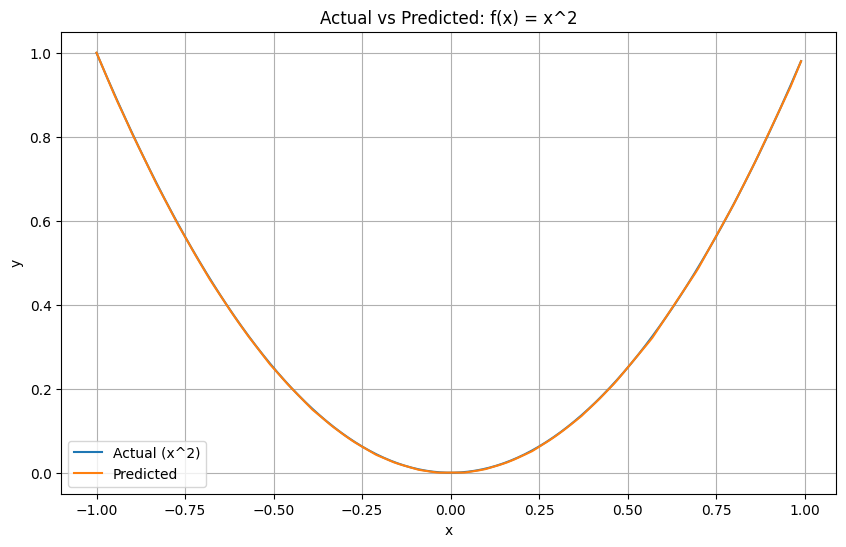

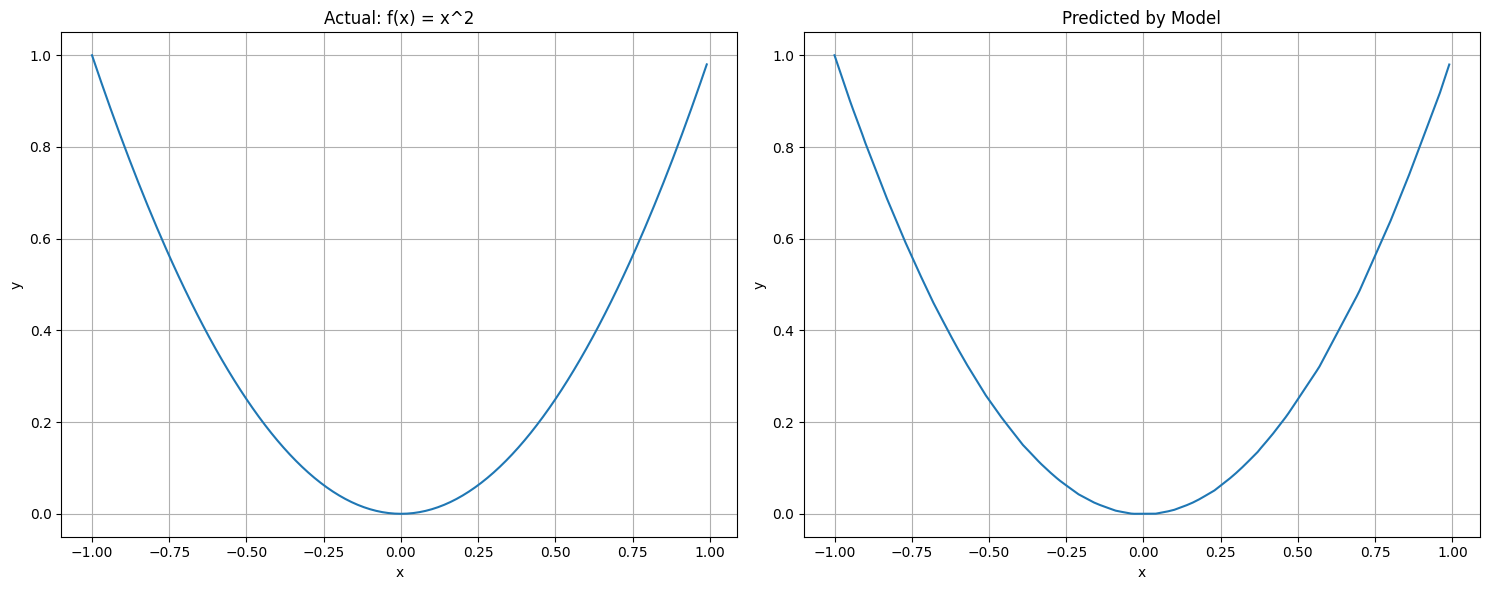

Mean Squared Error: 0.000001
Mean Absolute Error: 0.000836


In [44]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, label='Actual (x^2)')
plt.plot(xs, y_hats, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Actual vs Predicted: f(x) = x^2')
plt.legend()
plt.grid(True)
plt.show()

# separate plots:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(xs, ys)
ax1.set_title('Actual: f(x) = x^2')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)

ax2.plot(xs, y_hats)
ax2.set_title('Predicted by Model')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics
mse = np.mean((ys - y_hats)**2)
mae = np.mean(np.abs(ys - y_hats))
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")

In [ ]:
# Save test data and evaluations
with open(os.path.join(save_dir, 'test_data_and_evaluations.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Test Matrix', 'Actual exp(A)', 'Predicted exp(A)', 'Error'])
    for i in range(num_test):
        pred = predictions[i].cpu().numpy().flatten()
        actual = A_exp_test[i].flatten()
        writer.writerow([
            A_test[i].flatten().tolist(),
            actual.tolist(),
            pred.tolist(),
            (pred - actual).tolist()
        ])